# Utilising Language Models to Classify Texts into the Sustainable Development Goals

The United Nations’ Sustainable Development Goals (SDGs) are a call to action against global challenges, with goals covering poverty, public health and climate change, among others. Through these objectives not only the UN, but also corporations, education institutions, and governments can instigate positive targets, track the progress of their initiatives, and guide investments. Since 2015, the SDGs have been in place and the volume of text and related materials in existence has increased significantly. However, manually labelling these materials is extremely time consuming and expensive.

Within this tutorial we look at implementing transfer learning throguh Language Models on an NLP task to label text excerpts by related SDG. We will focus on the BERT model due to its relativley small size enabling quick training, as well as its previous good results in this domain.

Please do not edit cells that contain \\
"### DO NOT EDIT THIS CELL"  \\
but add code at the required locations marked by \\
"### PLEASE ADD YOUR CODE HERE"

MAKE SURE you are utilising a GPU too, otherwise it will take fooreeeveerrr!

In [ ]:
!pip install transformers

In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [ ]:
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 3.8 MB/s eta 0:00:00


In [ ]:
### DO NOT EDIT THIS CELL

import torch, sys, os, random, nlpaug

import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import nlpaug.augmenter.word as naw

from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from torch.nn import CrossEntropyLoss
from transformers.modeling_outputs import SequenceClassifierOutput


sns.set()

path = "./graphs/"
if not os.path.exists(path):
   # Create a new directory because it does not exist
   os.makedirs(path)
   print("The new graphs directory is created!")

path = "./models/"
if not os.path.exists(path):
   # Create a new directory because it does not exist
   os.makedirs(path)
   print("The new models directory is created!")

The new graphs directory is created!
The new models directory is created!


You have been given a pretrained model folder on Moodle for later use, please upload it now to the models folder and get on with the rest of the tutorial whilst it uploads! It is not super important if you are not able to get to this stage within the tutorial.

In [ ]:
### DO NOT EDIT THIS CELL

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
### DO NOT EDIT THIS CELL

def class_freq_plot(df_input, downsample):
    df1 = df_input.sort_values(by="sdg")
    df1 = df1['sdg'].value_counts(sort=False)
    plt.bar(range(1,17),df1)
    plt.xlim(.5,16.5)
    plt.xticks(range(1,17))
    if downsample:
        plt.title("Text excerpt frequency by SDG - Post Downsampling")
    else:
        plt.title("Text excerpt frequency by SDG")
    plt.xlabel("SDG")
    plt.ylabel("Number of Text Excerpts (Data Points)")


def character_count_plot(df_input):
    df_input['text'].str.len().hist(bins=50)
    plt.title("Character count per text excerpt")
    plt.xlabel("Number of Characters")
    plt.ylabel("Number of Text Excerpts (Data Points)")


def sentence_word_count(df_input):
    word_count_per_sentence = df_input['text'].str.split().map(lambda x: len(x))
    print("Average word length in Dataset : {}".format(np.mean(word_count_per_sentence)))


def word_count_plot(df_input):
    df_input['text'].str.split().map(lambda x: len(x)).hist(bins=40)
    plt.title("Word count per text excerpt")
    plt.xlabel("Number of Words")
    plt.ylabel("Number of Text Excerpts (Data Points)")


def average_word_count_plot(df_input):
    df_input['text'].str.split().apply(lambda x : [len(i) for i in x]). map(lambda x: np.mean(x)).hist(bins=40)
    plt.title("Average word length in the Dataset")
    plt.xlabel("Number of Characters")
    plt.ylabel("Number of Words")


def most_common_words_plot(df_input):
    stop=set(stopwords.words('english'))
    stop.update(['also','per','may', '-'])

    corpus=[]
    new = df_input['text'].str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1

    counter=Counter(corpus)
    most=counter.most_common()

    x, y= [], []
    for word,count in most[:70]:
        if (word.lower() not in stop):
            x.append(word)
            y.append(count)

    plt.xlabel("Number of instances")
    plt.title("Most common words in the Dataset")
    sns.barplot(x=y,y=x)


def eda_graphing(df_input, downsample=False):
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    class_freq_plot(df_input, downsample=downsample)

    plt.subplot(2, 2, 2)
    # character_count_plot(df_input)
    most_common_words_plot(df_input)

    plt.subplot(2, 2, 3)
    word_count_plot(df_input)

    plt.subplot(2, 2, 4)
    average_word_count_plot(df_input)

    plt.tight_layout()  # Adjust subplot parameters for better layout
    plt.show()

    return

For this problem we will be using the OSDG Community Dataset that can be found here: https://zenodo.org/records/5550238

In summary this is a volunteer run effort in which OSDG assigns a text excerpt a relevant SDG, and then between 3-8 volunteers choose to agree or disagree with this set label. Once an excerpt has been assigned a label it can't be assigned another, leading to only singlly labelled data. More details can be found at the data source.

We have provided you with the dataset on Moodle so it can also be directly added to your drive from there. Then adjust your file path below:

In [ ]:
### PLEASE ADD YOUR CODE HERE

file_xlsx = '/content/drive/MyDrive/Colab Notebooks/COMP0173/SDG_NLP_Classification/osdg-community-data-v2023-10-01.xlsx' #file name needs to change this to make it general use

df_tot = pd.read_excel(file_xlsx, 'osdg-community-data-v2023-10-01')  # select tab of the excel file
df_tot['sdg'] = df_tot['sdg'] - 1  # need a 0 class for inference, as the SDG labels start at 1
df_tot.head(20)

,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",4,1,8,0.777778
1,10.18356/eca72908-en,00028349a7f9b2485ff344ae44ccfd6b,Labour legislation regulates maximum working h...,10,2,1,0.333333
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,2,1,8,0.777778
3,10.1787/3726edff-en,0005d3e8b213d9e2cb967666e1aca2e9,Applied research is directed “primarily toward...,8,3,6,0.333333
4,10.1787/5k9b7bn5qzvd-en,0006a887475ccfa5a7f5f51d4ac83d02,The extent to which they are akin to corruptio...,2,1,2,0.333333
5,10.1787/9789264258211-6-en,0006d6e7593776abbdf4a6f985ea6d95,A region reporting a higher rate will not earn...,2,2,2,0.000000
6,10.1787/5js4xfgl4ks0-en,000b54717f2deea5d99055b4c1c2bf5a,These findings are consistent with previous wo...,9,2,7,0.555556
7,10.1787/9789264285712-7-en,000bc99895142f9b6795ddf402e16e9a,"Each section states the economic principle, re...",5,2,6,0.500000
8,10.1787/9789264117563-8-en,000bfb17e9f3a00d4515ab59c5c487e7,The Israel Oceanographic and Limnological Rese...,5,0,3,1.000000
9,10.18356/805b1ae4-en,001180f5dd9a821e651ed51e30d0cf8c,Previous chapters have discussed ways to make ...,1,0,3,1.000000


labels_positive/labels_negative relate to the number of volunteers that agreed/disagreed with the assigned label by OSDG.

Note that the SDG column has been shifted down by 1 so that the first SDG is now labelled as 0. This is so that the classifier will correctly work as it must be initiated from 0.

Looking at excerpt index 1 and 16 there are more negative labels than positive, going forward we will remove these but is this necessarily the right choice?

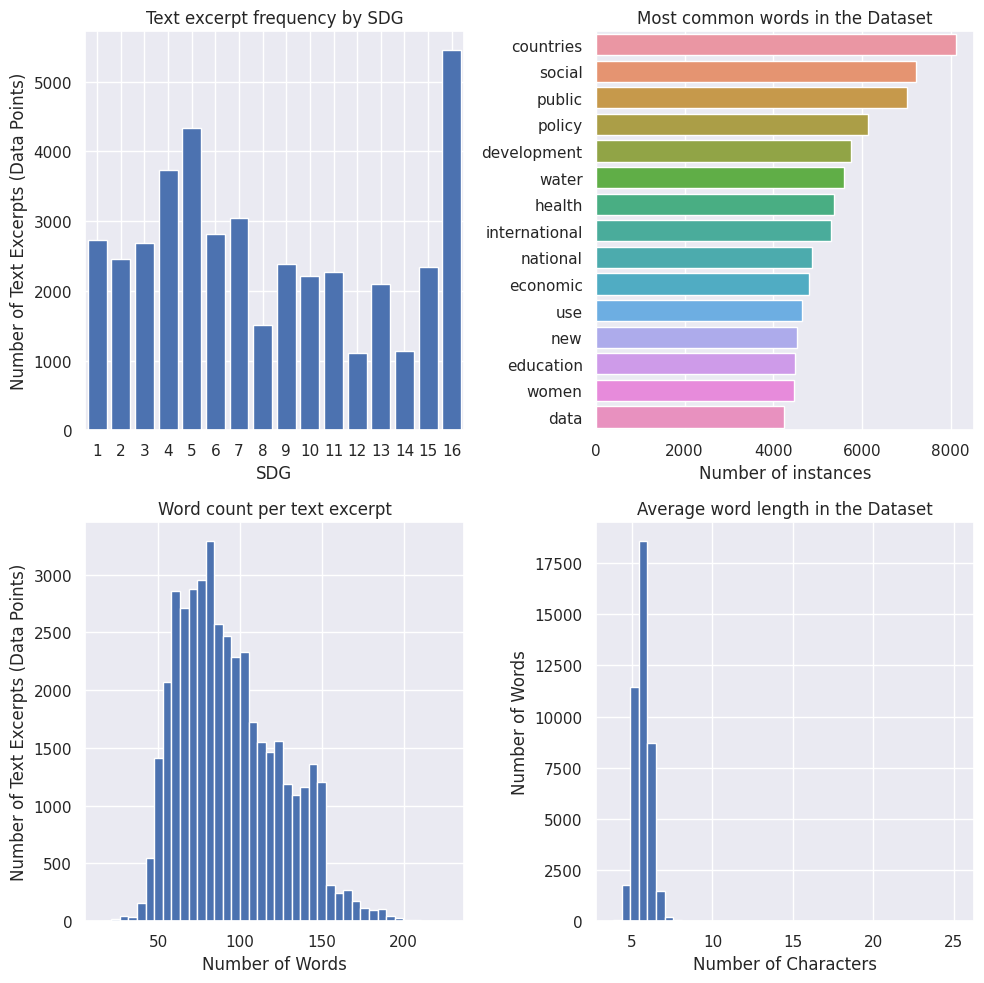

In [ ]:
### DO NOT EDIT THIS CELL

eda_graphing(df_tot)

It's clear we have a heavily imbalanced dataset, also with "noisy" labels.

As an initial attempt to create a better model we reduce imbalance by undersampling from the majority classes (e.g. SDG5, SDG16, etc). We also reduce noise by removing data with an agreement score less than 80\%.

However, we are lucky in the sense that the sentence lengths are all below 512 words. BERT has a token limit of 512 (with a token being a representation for a word) so our data will be able to fit in entirety, and we may even be able to speed up computation by reducing the token limit of the model.

In theory Transformer based approaches can taken an arbitrary amount of tokens even with fixed parameters, but are limited in application as memory scales by $O(n^2)$.

In [ ]:
### PLEASE ADD YOUR CODE HERE

def downsample_func(df_input):
    min_samples = df_input['sdg'].value_counts().min()
    downsampled_df = df_input.groupby('sdg', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))
    downsampled_df = downsampled_df.sort_index()

    return downsampled_df

def data_prep(df_input, downsample):
    random_seed = 42

    og_length = len(df_input)
    df_tot = df_input.drop(df_input[df_input['labels_negative'] > df_input['labels_positive']].index)  # drop data where more labellers disagree than agree
    new_length = len(df_tot)
    print("Roughly {:.2f}% of labels in the original Dataset had more negative labels than positive".format((og_length - new_length) * 100 / og_length))

    df = df_tot[['text', 'sdg', 'agreement']]  # remove unneccesary data from the dataset
    df_copy = df.copy()

    ### Add a train, val, test split below that relates to 70/15/15, please also stratify
    ### We can do this by splitting relating to index number

    X_train, X_val_test, y_train, y_val_test = train_test_split(df_copy.index.values,
                                                                df_copy.sdg.values,
                                                                test_size=0.30,
                                                                random_state=random_seed, #seed to get replicable results
                                                                stratify=df_copy.sdg.values) #train-test split for unbalanced data



    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=0.5,
                                                    random_state=random_seed, #seed to get replicable results
                                                    stratify=y_val_test) #train-test split for unbalanced data

    df_copy['data_type'] = ['not_set']*df_copy.shape[0]  # to tell us whether row in dataset is used for train/val/test.

    ### We now want to assign a data_type label to the corresponding data split index
    ### Assign a "train"/"val"/"test" label to the corresponding data. HINT using df.loc may help

    df_copy.loc[X_train, 'data_type'] = 'train'
    df_copy.loc[X_val, 'data_type'] = 'val'
    df_copy.loc[X_test, 'data_type'] = "test"

    ### Please drop data from the training set that has an agreement score of less than 0.8

    df_copy = df_copy.drop(df_copy[(df_copy['agreement'] < 0.8) & (df_copy['data_type'] == "train")].index)

    if downsample:
      df_copy = downsample_func(df_copy)

    print(df_copy.groupby(['data_type'])['text'].count())

    sentence_word_count(df_copy)

    return df_copy

Roughly 14.58% of labels in the original Dataset had more negative labels than positive
data_type
test     1898
train    3464
val      1902
Name: text, dtype: int64
Average word length in Dataset : 92.51528083700441


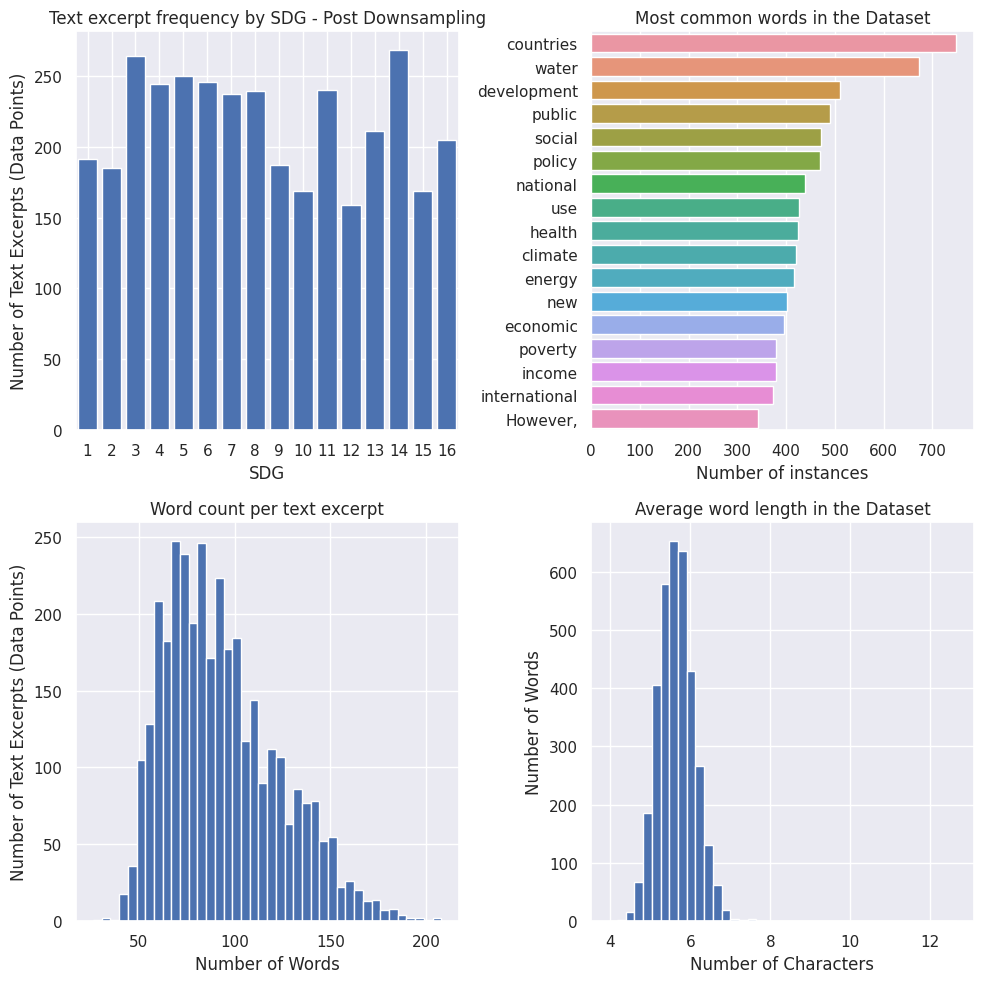

In [ ]:
### DO NOT EDIT THIS CELL

df_for_model = data_prep(df_tot, downsample=True)
eda_graphing(df_for_model[df_for_model['data_type'] == "train"], downsample=True)

Notice the improved data balance, however also note the reduction in data points! Will we still have enough data to achieve good inference? \\

In the following cell we initialise our pretrained BERT class. HuggingFace host a suite of pre-trained language models that can easily be installed and used for futher fine tuning on domain specific tasks. In the following code cell we will walk you through writing it yourself !!

In summary we first need to tokenise our data (i.e. convert words into numerical values as well as remove punctuation etc). Once tokenised we can run the data through a pretrained HuggingFace BERT model using PyTorch.


For more details the source code is here: https://huggingface.co/docs/transformers/model_doc/bert

In [ ]:
### PLEASE ADD YOUR CODE HERE

class BERTModel:
    def __init__(self, model: str, df, custom_loss=False, epochs=4):
        self.model = model
        self.df = df
        self.model_save_path = os.getcwd() + '/models/'
        self.batch_size = 32
        self.epochs = epochs
        self.seed_val = 42

        self.max_tokens = 216  # can be a value up to 512

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Device : {}".format(self.device))

        self.custom_loss = custom_loss

    def tokeniser(self):
        casing = False
        if 'uncased' in self.model:
            casing = True

        ### From BERTTokenizer please initialise a pretrained tokeniser relating
        ### to our input self.model and with our casing conditional function

        tokeniser = BertTokenizer.from_pretrained(self.model, do_lower_case=casing)

        def tokeniser_func(tokeniser, df_type):
            tokeniser = tokeniser.batch_encode_plus(self.df[self.df.data_type == df_type].text.values,
                                                          add_special_tokens=True,    # knows stop gaps for sentences
                                                          max_length=self.max_tokens, # hyperparam that sets limit of model, larger means bigger model so slower training but means most sentences can be put in
                                                          padding="max_length",       # 0 padding to get to max length
                                                          return_attention_mask=True,
                                                          return_tensors='pt',        # will return pytorch tensors
                                                          truncation=True
                                                          )

            input_ids = tokeniser['input_ids']
            attention_masks = tokeniser['attention_mask']
            labels = torch.tensor(self.df[self.df.data_type == df_type].sdg.values)

            return input_ids, attention_masks, labels

        input_ids_train, attention_masks_train, labels_train = tokeniser_func(tokeniser, "train")
        input_ids_val, attention_masks_val, labels_val = tokeniser_func(tokeniser, "val")
        input_ids_test, attention_masks_test, labels_test = tokeniser_func(tokeniser, "test")

        dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
        dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
        dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

        def token_length_cover(input_ids_list):
            df_type = ["Train", "Val ", "Test"]
            for indec, input_ids in enumerate(input_ids_list):
                zero_count = 0
                for i in input_ids:
                    if 0 in i:
                        zero_count += 1

                print("{:.2f}% of {} sentences longer than {} tokens".format((len(input_ids) - zero_count) / len(input_ids) * 100, df_type[indec], self.max_tokens))


        token_length_cover([input_ids_train, input_ids_val, input_ids_test])

        print("Tokenisation complete")

        return dataset_train, dataset_val, dataset_test

    @staticmethod
    def f1_score_func(preds, labels):
        preds_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return f1_score(labels_flat, preds_flat, average='weighted')

    def per_class_acc(self, model, dataloader_test):
        _, predictions, true_vals = self.evaluate(model, dataloader_test)

        preds_flat = np.argmax(predictions, axis=1).flatten()
        labels_flat = true_vals.flatten()

        acc_per_class_bert = []

        for label in np.unique(labels_flat):
            y_preds = preds_flat[labels_flat == label]
            y_true = labels_flat[labels_flat == label]
            print(f'SDG: {label + 1}')
            acc_by_class = len(y_preds[y_preds == label]) / len(y_true)
            acc_per_class_bert.append(acc_by_class)
            print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)} = {round(acc_by_class, 3)}\n')

        return predictions, true_vals

    def confusion_matrices(self, model, dataloader_test):
        predictions, true_vals = self.per_class_acc(model, dataloader_test)
        predicts = np.argmax(predictions, axis=1).flatten()

        cm = confusion_matrix(true_vals, predicts)

        fig, ax = plt.subplots(figsize=(14,14))
        cm_perc = np.zeros((16,16))

        x_axis_labels = range(1,17)
        y_axis_labels = range(1,17)

        for i in range(16):
          cm_perc[i] = (cm[i]/np.sum(cm,axis = 1)[i])

        sns.heatmap(cm_perc, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True,  fmt='.1%',cmap='Blues')

        ax.set_ylabel('Actual Values')
        ax.set_xlabel('Predicted Values')

        save_name = './graphs/confusion_matrix'
        plt.title(save_name, fontsize=12)
        plt.show()

        return predictions, true_vals, predicts

    def total_classification_report(self, model, dataloader_test):
        predictions, true_vals, predicts = self.confusion_matrices(model, dataloader_test)
        report = classification_report(y_true=true_vals, y_pred=predicts,  digits=4, output_dict=True)
        metrics_report = pd.DataFrame(report).transpose()

    def trained_model_eval(self, input_model):
        _, _, dataset_test = self.tokeniser()
        dataloader_test = DataLoader(dataset_test, sampler=SequentialSampler(dataset_test), batch_size=self.batch_size)
        model = BertForSequenceClassification.from_pretrained(input_model)
        model.to(self.device)
        self.total_classification_report(model, dataloader_test)

    def evaluate(self, model, dataloader_val):

        ### Add a Torch evaluation call to freeze the weights
        ### Will leave this mostly to you with hints:
        ### Need to disable gradients when running inputs into model since not backpropagating
        ### We want the output predictions as the respective logits for the F1 score

        model.eval()

        loss_val_total = 0
        predictions, true_vals = [], []

        for batch in tqdm(dataloader_val):
            batch = tuple(b.to(self.device) for b in batch)

            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2],
                      }

            with torch.no_grad():  # disable the gradients, as you dont need them since you are not backpropagating
                outputs = model(**inputs)

            loss_val_total += outputs.loss.item()

            logits = outputs.logits.detach().cpu().numpy()
            label_ids = inputs['labels'].cpu().numpy()
            predictions.append(logits)
            true_vals.append(label_ids)

        loss_val_avg = loss_val_total / len(dataloader_val)

        predictions = np.concatenate(predictions, axis=0)
        true_vals = np.concatenate(true_vals, axis=0)

        return loss_val_avg, predictions, true_vals

    def trainer(self):
        dataset_train, dataset_val, dataset_test = self.tokeniser()

        ### Load a pre-trained BERT Sequence Classification model that does not
        ### output the attentions but does output the hidden states

        if not self.custom_loss:
            model = BertForSequenceClassification.from_pretrained(self.model, num_labels=len(self.df['sdg'].unique()),
                                                                  output_attentions=False, output_hidden_states=True
                                                                )

        ### FILL IN LATER ON - add a model from our custom loss class
        else:
            train_data = self.df[(self.df["data_type"] == "train") | (self.df["data_type"] == "val")]
            total_samples = len(train_data)
            num_samples_per_class = train_data.groupby(['sdg'])['text'].count().tolist()
            num_classes = len(num_samples_per_class)

            weight_tensor = [total_samples / (num_samples * num_classes) for num_samples in num_samples_per_class]  # to calculate individual class weight
            weight_tensor = torch.tensor(weight_tensor).to(self.device)

            model = Custom_Loss.from_pretrained(self.model, weight_tensor=weight_tensor, num_labels=len(self.df['sdg'].unique()),
                                               output_attentions=False, output_hidden_states=True
                                              )

        ### Create the train/val/test Dataloaders from the dataset, randomise
        ### the train set, but sequentalise the other two

        dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=self.batch_size)
        dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=self.batch_size)
        dataloader_test = DataLoader(dataset_test, sampler=SequentialSampler(dataset_test), batch_size=self.batch_size)

        ### Add an AdamW optimizer with lr=1e-5 and eps=1e-8

        optimiser = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)

        scheduler = get_linear_schedule_with_warmup(optimiser, num_warmup_steps=0, num_training_steps=len(dataloader_train) * self.epochs)

        model.to(self.device)

        for epoch in tqdm(range(1, self.epochs + 1)):

            model.train()

            loss_train_total = 0  # set train loss for each initial batch to zero

            # progress-bar: how many batches have been trained / how many are left to go.
            progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch),
                                leave=False,  # let it overwrite itself after each epoch
                                disable=False)

            for batch in progress_bar:
                ### Set the grads to zero in the model, then add each element in
                ### the batch to the device

                model.zero_grad()
                batch = tuple(b.to(self.device) for b in batch)

                inputs = {'input_ids': batch[0],
                          'attention_mask': batch[1],
                          'labels': batch[2],
                          }

                ### Add all inputs into the model to extract outputs, check source
                ### code for full details on outputs as there are multiple. Add
                ### the loss to the loss_train_total then run backprop

                outputs = model(**inputs)  # there's a bunch of them check source code for exact details
                loss_train_total += outputs.loss.item()  # add loss item for each batch
                outputs.loss.backward()  # it performs backpropagation and calculates the gradients, using the loss function criterion built into BERT from huggingface

                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # clip our gradients to norm of 1 per layer, preventing grads to become too small (or too big)

                ### Take a step in the optimiser and scheduler

                optimiser.step()
                scheduler.step()

                # update progress bar showing average sample loss per batch (doing a small dictionary)
                progress_bar.set_postfix({'training_loss': '{:.3f}'.format(outputs.loss.item() / len(batch))})

            tqdm.write(f'\nEpoch {epoch}')

            loss_train_avg = loss_train_total / len(dataloader_train)
            tqdm.write(f'Training loss: {loss_train_avg}')

            val_loss, predictions, true_vals = self.evaluate(model, dataloader_validation)  # does the same as training, but not changing gradients (so no back-propagation). We only care about loss and logits (i.e. the prediction values)
            val_f1 = self.f1_score_func(predictions, true_vals)  # weighted f1 score, feeding it the prediction and true values to calculate "accuracy"
            tqdm.write(f'Validation loss: {val_loss}')
            tqdm.write(f'F1 Score (Weighted): {val_f1}')

        # self.model_save_path += 'finetuned_BERT_model.model'
        # model.save_pretrained(self.model_save_path, from_pt=True)

        self.total_classification_report(model, dataloader_test)

Device : cuda


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

1.39% of Train sentences longer than 216 tokens
2.05% of Val  sentences longer than 216 tokens
1.53% of Test sentences longer than 216 tokens
Tokenisation complete


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/109 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.4623019717155246


  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss: 2.139873516559601
F1 Score (Weighted): 0.4662107567581044


Epoch 2:   0%|          | 0/109 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.6971220040540083


  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss: 1.6265894095102946
F1 Score (Weighted): 0.646422864461023


Epoch 3:   0%|          | 0/109 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.3191989047811665


  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss: 1.48902139266332
F1 Score (Weighted): 0.6707352752521462


  0%|          | 0/60 [00:00<?, ?it/s]

SDG: 1
Accuracy: 76/133 = 0.571

SDG: 2
Accuracy: 112/134 = 0.836

SDG: 3
Accuracy: 83/88 = 0.943

SDG: 4
Accuracy: 91/101 = 0.901

SDG: 5
Accuracy: 85/99 = 0.859

SDG: 6
Accuracy: 88/101 = 0.871

SDG: 7
Accuracy: 94/111 = 0.847

SDG: 8
Accuracy: 49/115 = 0.426

SDG: 9
Accuracy: 69/134 = 0.515

SDG: 10
Accuracy: 4/151 = 0.026

SDG: 11
Accuracy: 79/110 = 0.718

SDG: 12
Accuracy: 79/148 = 0.534

SDG: 13
Accuracy: 83/124 = 0.669

SDG: 14
Accuracy: 88/92 = 0.957

SDG: 15
Accuracy: 102/136 = 0.75

SDG: 16
Accuracy: 88/121 = 0.727



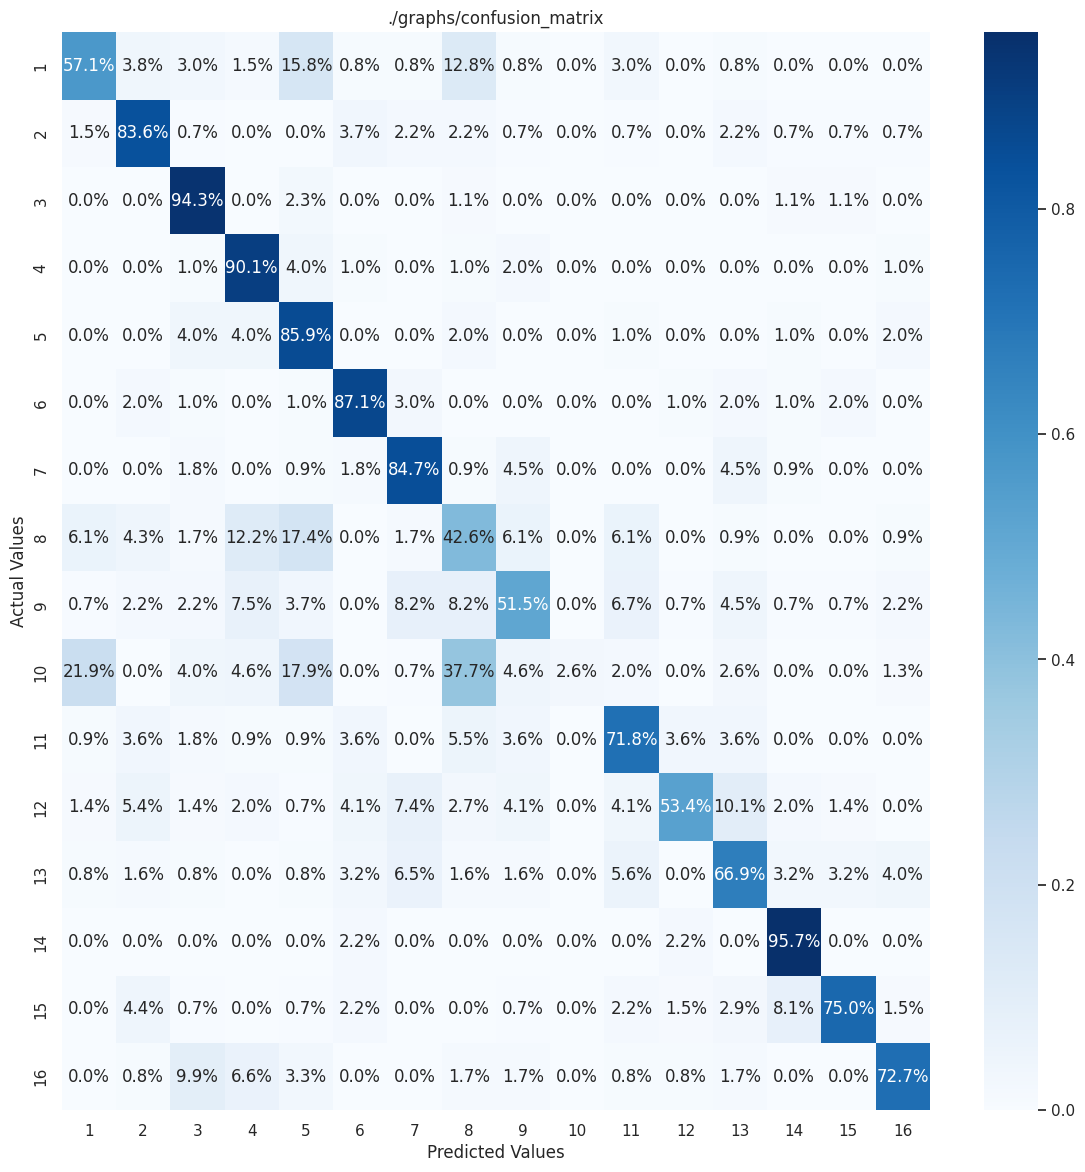

In [ ]:
### DO NOT EDIT THIS CELL

torch.manual_seed(42)
torch.cuda.empty_cache()
model_type = 'bert-base-uncased'  # 'bert-base-cased'  # casing refers to whether we leave capital letters in or not, this affects tokens
normal_BERT = BERTModel(model_type, df_for_model, epochs=3)
normal_BERT.trainer()

### While waiting to train, read through the next section and begin to answer the qs

We've made a BERT model that is able to classify text by SDG but.. \\
SPOILERS - the model doesn't perform very well on the test data! It really struggles on SDG 8, 9, 10, 12.

We've not only removed noise from the training data by filtering by agreement score, but also downsampled the data. Noise still exists on our test data and so our model does not perform well on out of sample data. Downsampling can also be a bad idea - we lose information from the overall dataset which can lead to data bias, the model performance is heavily dependent on the specific random sample taken.

We have done this to restrict the dataset so that we can have a go at programming and training a pretrained BERT model within an hour tutorial! However, within this next section we look at better data pre-processing and augmentation techniques, then compare their results to the initial "baseline".

# Custom Loss Function
With class imbalance we can implement weighted loss functions that are dependent on the number of class instances. Normally this is an easy fit within a self built model, but with an imported model it can be more challenging.

Before we move onto increasing the dataset size we can try these custom losses on our smaller dataset.

We will go over how to implement custom losses into HuggingFace models below. By creating a subclass of the HuggingFace model we are able to inherit all the attributes required but also customise as we need. To do this, copy the parts that you plan to update from the source code, any other functions will be inherited from the superclass.

 We can replace the inbuilt loss with the torch.CrossEntropyLoss and use a tensor of weights (that have been calculated for you in the BERTModel class) as input into the function. Once a new subclass has been made, scroll up to the BERTModel class and fill in the gap on loading your custom HuggingFace model.

In [ ]:
### PLEASE ADD YOUR CODE HERE

# To find the original model you can search the source code and use it as a
# SuperClass to this custom one

# For help it is here: https://github.com/huggingface/transformers/blob/9aeacb58bab321bc21c24bbdf7a24efdccb1d426/src/transformers/modeling_bert.py

### Initialise a subclass of BertForSequenceClassification and add in the custom loss
### torch.CrossEntropyLoss enables a weighted input tensor, this can be added in
### the class initialisation

class Custom_Loss(BertForSequenceClassification):
    def __init__(self, *args, weight_tensor, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight_tensor = weight_tensor

    def forward(
            self,
            input_ids = None,
            attention_mask = None,
            token_type_ids = None,
            position_ids = None,
            head_mask = None,
            inputs_embeds = None,
            labels = None,
            output_attentions = None,
            output_hidden_states = None,
            return_dict = None,
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss_fct = CrossEntropyLoss(weight = self.weight_tensor)
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

Device : cuda
1.39% of Train sentences longer than 216 tokens
2.05% of Val  sentences longer than 216 tokens
1.53% of Test sentences longer than 216 tokens
Tokenisation complete


Some weights of Custom_Loss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/109 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.470481166052162


  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss: 2.144041015704473
F1 Score (Weighted): 0.49561212303429075


Epoch 2:   0%|          | 0/109 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.7178789333465996


  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss: 1.6359671612580617
F1 Score (Weighted): 0.658940871489928


Epoch 3:   0%|          | 0/109 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.3396510935704642


  0%|          | 0/60 [00:00<?, ?it/s]

Validation loss: 1.4984987239042917
F1 Score (Weighted): 0.6912120286877609


  0%|          | 0/60 [00:00<?, ?it/s]

SDG: 1
Accuracy: 77/133 = 0.579

SDG: 2
Accuracy: 112/134 = 0.836

SDG: 3
Accuracy: 83/88 = 0.943

SDG: 4
Accuracy: 91/101 = 0.901

SDG: 5
Accuracy: 83/99 = 0.838

SDG: 6
Accuracy: 88/101 = 0.871

SDG: 7
Accuracy: 94/111 = 0.847

SDG: 8
Accuracy: 47/115 = 0.409

SDG: 9
Accuracy: 71/134 = 0.53

SDG: 10
Accuracy: 20/151 = 0.132

SDG: 11
Accuracy: 79/110 = 0.718

SDG: 12
Accuracy: 84/148 = 0.568

SDG: 13
Accuracy: 83/124 = 0.669

SDG: 14
Accuracy: 87/92 = 0.946

SDG: 15
Accuracy: 102/136 = 0.75

SDG: 16
Accuracy: 89/121 = 0.736



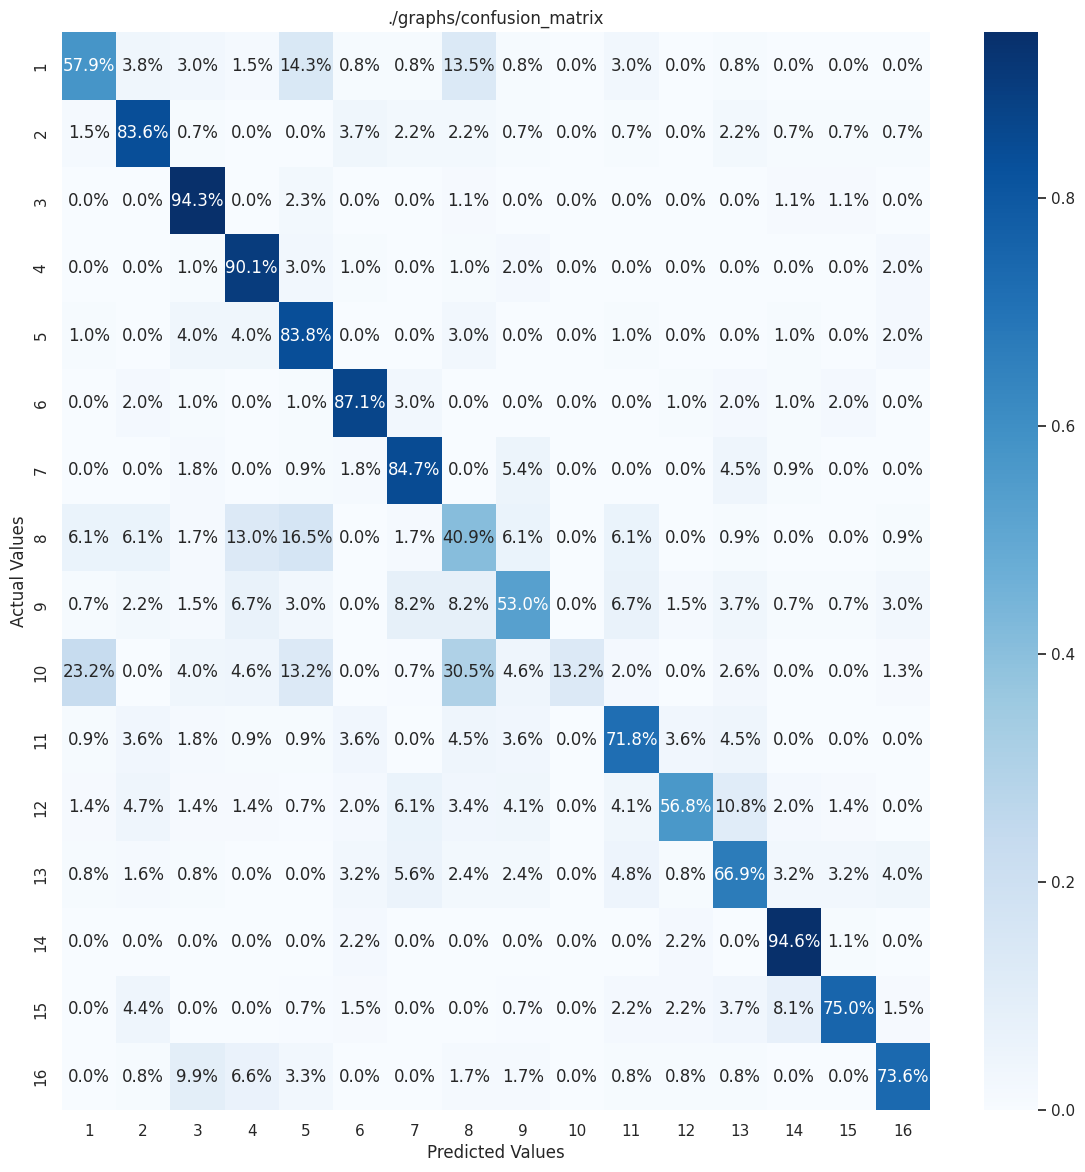

In [ ]:
### DO NOT EDIT THIS CELL

torch.manual_seed(42)
torch.cuda.empty_cache()
model_type = 'bert-base-uncased'  # 'bert-base-cased'  # casing refers to whether we leave capital letters in or not, this effects tokens
normal_BERT = BERTModel(model_type, df_for_model, custom_loss=True, epochs=3)
normal_BERT.trainer()

### While waiting to train, read through the next section and begin to answer the qs

SPOILERS this custom loss has slightly improved results, but not by much, it is quite a simplified approach! For future work you can now greatly edit classes, even though it is a pretrained model. If you are interested, with this setup it is easy to replace our loss with more intricate losses such as Supervised Contrastive Losses etc.

## Adjusting agreement score (noise in the dataset)
Initially we removed all data that had an agreement score less than 80\%. Not only does this greatly reduce the dataset but it also decreases the data noise. Both these attributes can hurt performance, and so instead we reverse this to increase the models' performance on out of sample data. \\

We remove this agreeement score filter - although for personal testing you could treat it as a hyperparameter!

## Oversampling our dataset
When working within Computer Vision for low data regimes or imbalanced datasets oversampling techniques work by transforming subsets of the data. For instance applying zooms, rotations, flips etc can reiterate existing image data points without being exact copies.

In the NLP domain we can apply similar techniques due to the highly interconnected nature of linguistics. For instance:
- Synonym Replacement
- Forwards and Back Translation
- Pairword swapping
- etc.

These can be applied at various granularity levels, sentences → words → characters.

We will focus on word synonym replacements in the following section using the NLPAug library:

In [ ]:
### PLEASE ADD YOUR CODE HERE

# Performing data augmentation with NLP AUG
def data_prep_and_augmentation(df_input):
    random_seed = 42

    df_tot = df_input.drop(df_input[df_input['labels_negative'] > df_input['labels_positive']].index)  # drop data where more labellers disagree than agree

    df = df_tot[['text','sdg']]  # remove unneccesary data from the dataset

    df_copy = df.copy()

    ### Again perform train/valid/test split of 70/15/15 and labelling the data
    ### in the dataframe

    X_train, X_val_test, y_train, y_val_test = train_test_split(df_copy.index.values,
                                                                df_copy.sdg.values,
                                                                test_size=0.30,
                                                                random_state=random_seed, #seed to get replicable results
                                                                stratify=df_copy.sdg.values) #train-test split for unbalanced data



    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=0.5,
                                                    random_state=random_seed,
                                                    stratify=y_val_test)

    df_copy['data_type'] = ['not_set']*df_copy.shape[0]  # to tell us whether row in dataset is used for training or validation. Create new column called "data type", initially set at "not-set"

    df_copy.loc[X_train, 'data_type'] = 'train' # fill data_type column depending on whether it's a train or validation example
    df_copy.loc[X_val, 'data_type'] = 'val'
    df_copy.loc[X_test, 'data_type'] = 'test'

    ############################################################################
    #### AUGMENTATION

    n_sent = 3  # number of times to oversample a text excerpt
    n_words = 25  # number of words to replace in a text excerpt
    cutoff_point = 8  # what is the split for minority/majority class

    df_count = df_copy.sort_values(by="sdg")
    df_count = df_count['sdg'].value_counts(sort=True)
    sdg_aug_list = list(df_count.index)[cutoff_point:]
    sdg_aug_delta = [df_count.iloc[cutoff_point-1] - x for x in list(df_count)][cutoff_point:]  # remember negative 1 as our SDGs go from 0-15 in the model but 1-16 in real life

    index = df_copy.last_valid_index() + 1

    df_aug = df_copy[df_copy['data_type'] =='train']

    for index, sdg_aug in enumerate(sdg_aug_list):
        df_sample = df_copy['text'][df_copy['data_type'] == 'train'][df_copy['sdg'] == (sdg_aug)]
        for i in tqdm(random.sample(list(df_sample.index), sdg_aug_delta[index] // n_sent)):
            text = df_sample[i]
            aug = naw.SynonymAug(aug_src='wordnet', aug_max = n_words) # change n_words
            aug = aug.augment(text, n = n_sent) # create n_sent new variations for each excerpt

            for i in aug:
                new_row = {'text':i, 'sdg':sdg_aug,'data_type':'train'}
                df_aug = pd.concat([df_aug, pd.DataFrame(new_row, index=[index])], ignore_index=True)

                index += 1

    df_aug = pd.concat([df_aug, df_copy[df_copy['data_type']=='val'], df_copy[df_copy['data_type']=='test']])
    df_aug = df_aug.sample(frac=1)  # shuffling the dataframe as otherwise we have ordering post augmentation

    return df_aug

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

  0%|          | 0/395 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

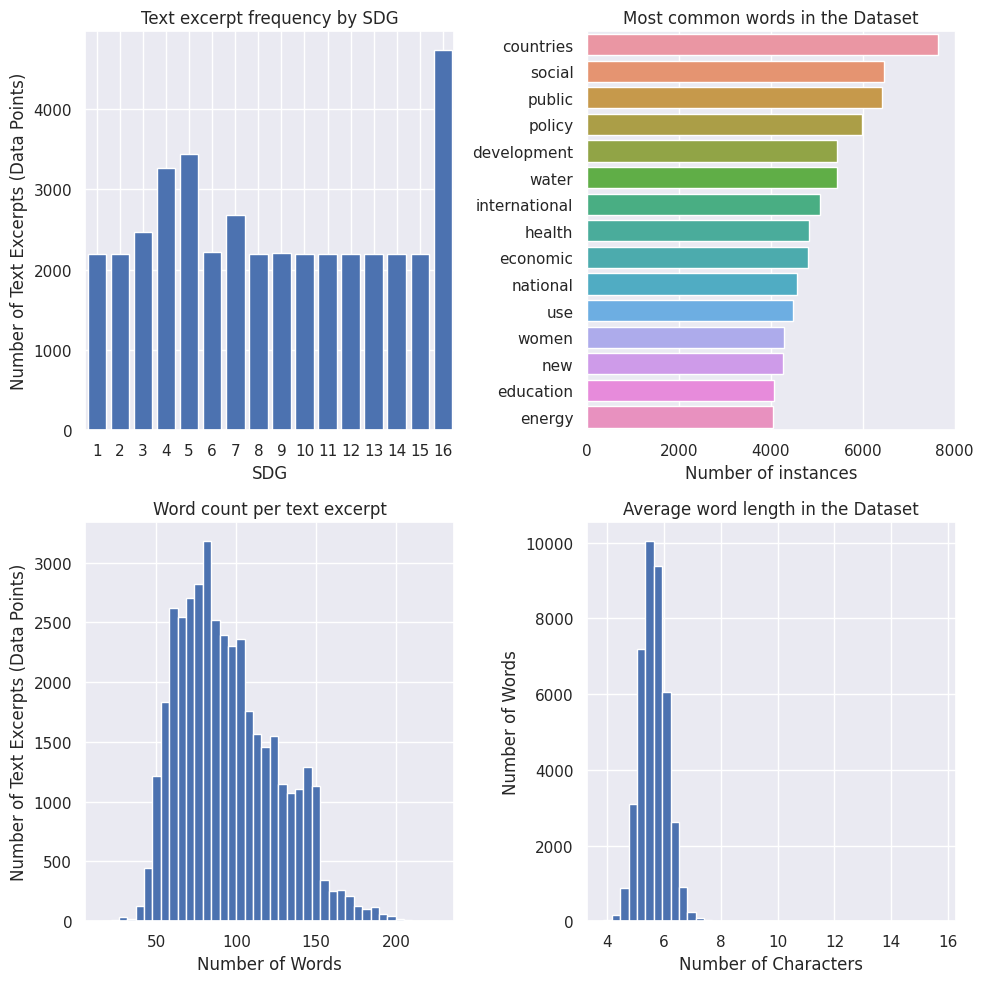

In [ ]:
### DO NOT EDIT THIS CELL

df_for_model_oversample = data_prep_and_augmentation(df_tot)
eda_graphing(df_for_model_oversample, downsample=False)

After all these changes we now have a larger dataset that will take roughly an hour or so to train. Instead we have provided you with the pretrained model to enable model comparison. Hopefully by now the folder has uploaded so you can run the following cells.

However, if you have the time and the will then uncomment the following code to rerun the model on the new dataset. Also you can try other (better) data augmentation methods to see the effect on model performance. Make sure though that you only apply augmentation to the training data.

In [ ]:
### DO NOT EDIT THIS CELL

# torch.manual_seed(42)
# torch.cuda.empty_cache()
# model_type = 'bert-base-uncased'  # 'bert-base-cased'
# normal_BERT = BERTModel(model_type, df_for_model_oversample)
# normal_BERT.trainer()

Device : cuda
1.83% of Train sentences longer than 216 tokens
2.14% of Val  sentences longer than 216 tokens
1.86% of Test sentences longer than 216 tokens
Tokenisation complete


  0%|          | 0/170 [00:00<?, ?it/s]

SDG: 1
Accuracy: 244/329 = 0.742

SDG: 2
Accuracy: 235/280 = 0.839

SDG: 3
Accuracy: 336/371 = 0.906

SDG: 4
Accuracy: 452/489 = 0.924

SDG: 5
Accuracy: 477/515 = 0.926

SDG: 6
Accuracy: 284/332 = 0.855

SDG: 7
Accuracy: 352/403 = 0.873

SDG: 8
Accuracy: 80/208 = 0.385

SDG: 9
Accuracy: 266/332 = 0.801

SDG: 10
Accuracy: 181/273 = 0.663

SDG: 11
Accuracy: 249/311 = 0.801

SDG: 12
Accuracy: 101/148 = 0.682

SDG: 13
Accuracy: 227/274 = 0.828

SDG: 14
Accuracy: 142/152 = 0.934

SDG: 15
Accuracy: 252/300 = 0.84

SDG: 16
Accuracy: 700/710 = 0.986



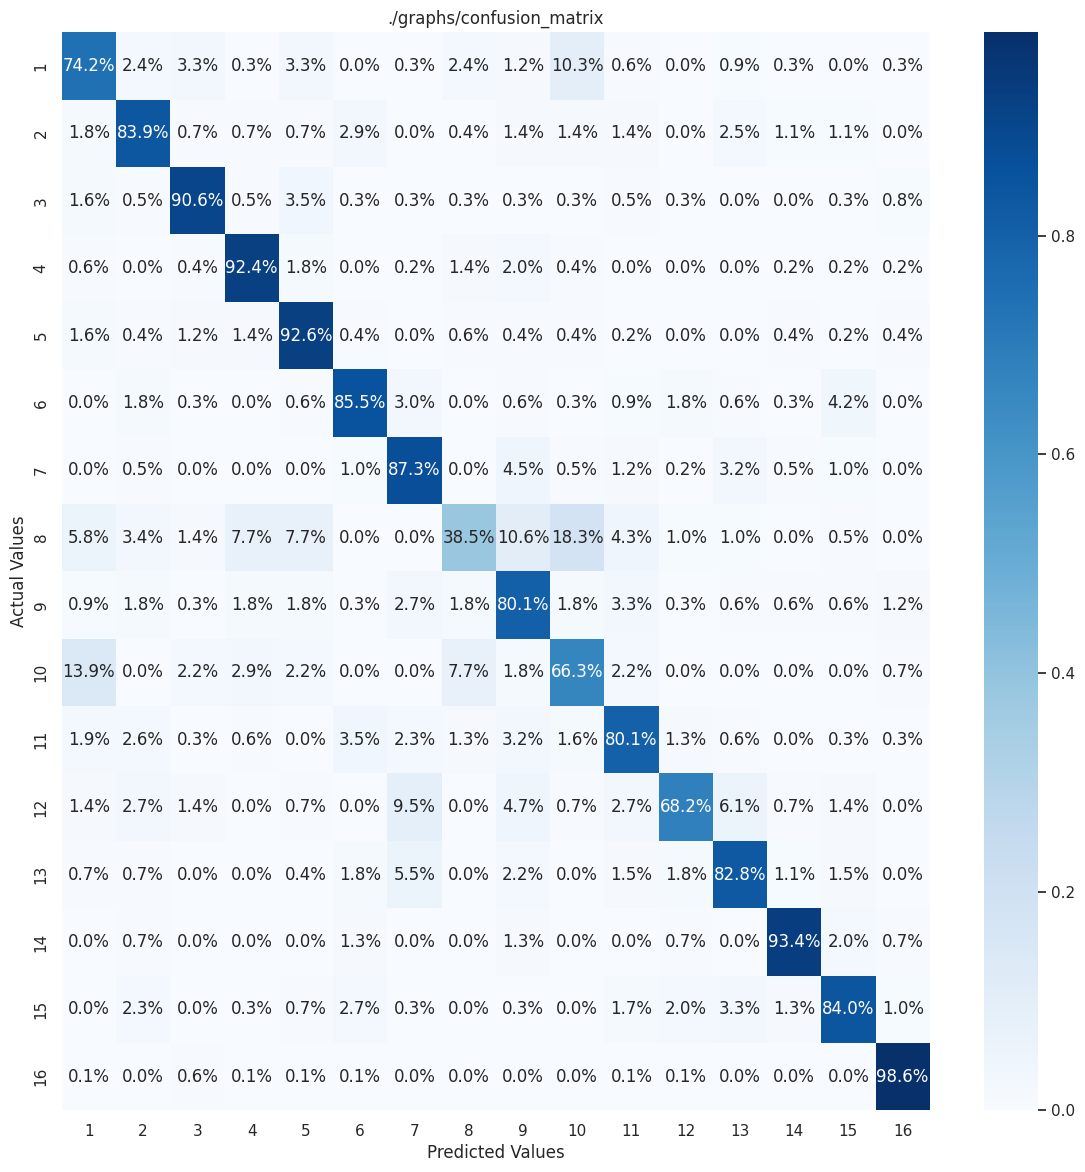

In [ ]:
### PLEASE ADD YOUR CODE HERE
### loading pretrained model and running the classification report on it

torch.manual_seed(42)
torch.cuda.empty_cache()
model_type = 'bert-base-uncased'
normal_BERT = BERTModel(model_type, df_for_model_oversample)
normal_BERT.trained_model_eval(os.getcwd() + '/models/' + 'finetuned_BERT_model.model')  #### you may need to adjust where the model is located

This model performs much better, however it still greatly struggles with SDG 8! It is always important to get a class accuracy breakdown as a simple F1 score can hide imbalances in class prediciton. This is not due to lack of data, and instead further work must look into the difficulties in predicting this class.

This has been a brief overview of utilising pre-trained language models in a sustainable domain. It is quite a simple approach without much attention to hyperparameter tuning or an in-depth anaylsis of data cleaning/augmentation so take the results with a grain of salt. However, if you are interested in this problem there are many future avenues that could be explored, eg: \\
- Is it possible to infer multi labels from this singly labelled data? SDGs are highly interconnected and only recieving one label misses out on a large swathe of information. The field of Weakly-Supervised Learning may help. \\
- We have a notion of label "softness" in the agreement score. In this tutorial we have largely ignored this to simplify the problem. However, with access to this extra information how could we incorporate them into the model for more accurate inference? \\
- Is removing data with more negative labels than positive labels a good idea? This again could be seen as label noise, but also thinking of the downstream task maybe the data isn't useful in its addition. \\
- There's no SDG 17 in the data, is there a way to still predict this using conditional labels? SDG 17 is a combination of the other SDGs so maybe it would be possible to classify it with only access to the 16 other labels, but maybe not !!

These are but a few ideas!